# Amazon Alexa Review - Sentiment Analysis

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


### Exploratory Data Analysis

In [3]:
import pandas as pd

# Load the data with column names
data = pd.read_csv(r"Data\testData.csv", sep=',', engine='python', names=['label', 'review'])

print(f"Dataset shape : {data.shape}")

Dataset shape : (19999, 2)


In [4]:
data.head()

,label,review
0,1,My lovely Pat has one of the GREAT voices of h...
1,1,Despite the fact that I have only played a sma...
2,0,I bought this charger in Jul 1003 and it worke...
3,1,Check out Maha Energy's website. Their Powerex...
4,1,Reviewed quite a bit of the combo players and ...


In [5]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['label' 'review']


In [6]:
#Check for null values

data.isnull().sum()

label     0
review    0
dtype: int64

There is one record with no 'review' (null value)

In [7]:
#Getting the record where 'review' is null 

data[data['review'].isna() == True]

,label,review


In [8]:
#We will drop the null record

data.dropna(inplace=True)

In [9]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (19999, 2)


In [10]:
#Creating a new column 'length' that will contain the length of the string in 'review' column

data['length'] = data['review'].apply(len)

In [11]:
data.head()

,label,review,length
0,1,My lovely Pat has one of the GREAT voices of h...,523
1,1,Despite the fact that I have only played a sma...,742
2,0,I bought this charger in Jul 1003 and it worke...,301
3,1,Check out Maha Energy's website. Their Powerex...,190
4,1,Reviewed quite a bit of the combo players and ...,382


The 'length' column is new generated column - stores the length of 'review' for that record. Let's check for some sample records

In [12]:
#Randomly checking for 10th record

print(f"'review' column value: {data.iloc[10]['review']}") #Original value
print(f"Length of review : {len(data.iloc[10]['review'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'review' column value: I currently live in Europe, and this is the book I recommend for my visitors. It covers many countries, colour pictures, and is a nice starter for before you go, and once you are there.
Length of review : 185
'length' column value : 185


We can see that the length of review is the same as the value in the length column for that record

Datatypes of the features

In [13]:
data.dtypes

label      int64
review    object
length     int64
dtype: object

* rating, label and length are integer values <br>
* date, variation and verified_reviews are string values

### Analyzing 'label' column

This column refers to the label of the verified review

In [14]:
#Distinct values of 'label' and its count 

print(f"label value count: \n{data['label'].value_counts()}")

label value count: 
label
1    10213
0     9786
Name: count, dtype: int64


There are 2 distinct values of 'label' present - 0 and 1. Let's see what kind of review each value corresponds to.

label value = 0

In [15]:
#Extracting the 'review' value for one record with label = 0

review_0 = data[data['label'] == 0].iloc[0]['review']
print(review_0)

I bought this charger in Jul 1003 and it worked OK for a while. The design is nice and convenient. However, after about a year, the batteries would not hold a charge. Might as well just get alkaline disposables, or look elsewhere for a charger that comes with batteries that have better staying power.


In [16]:
#Extracting the 'review' value for one record with label = 1

review_1 = data[data['label'] == 1].iloc[1]['review']
print(review_1)

Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of songs in my other video game soundtracks. I must admit that one of the songs (Life-A Distant Promise) has brought tears to my eyes on many occasions.My one complaint about this soundtrack is that they use guitar fretting effects in many of the songs, which I find distracting. But even if those weren't included I would still consider the collection worth it.


From the above 2 examples we can see that label **0 is negative review** and **1 is positive review**

Let's plot the label value count in a bar graph

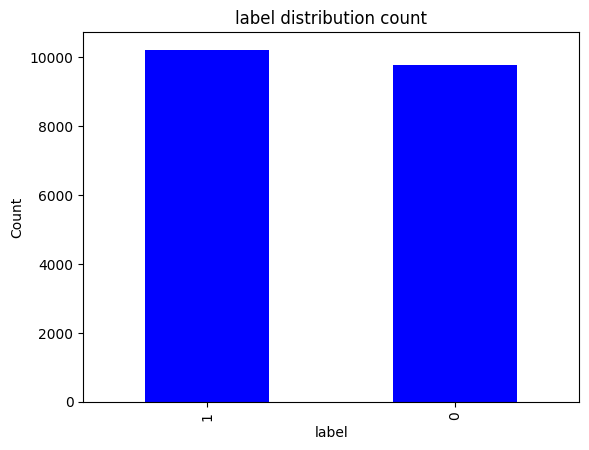

In [17]:
#Bar graph to visualize the total counts of each label

data['label'].value_counts().plot.bar(color = 'blue')
plt.title('label distribution count')
plt.xlabel('label')
plt.ylabel('Count')
plt.show()

In [18]:
#Finding the percentage distribution of each label - we'll divide the number of records for each label by total number of records

print(f"label value count - percentage distribution: \n{round(data['label'].value_counts()/data.shape[0]*100,2)}")

label value count - percentage distribution: 
label
1    51.07
0    48.93
Name: count, dtype: float64


label distribution <br>
* 51.3% reviews are positive <br>
* 48.7% reviews are negative

<Axes: ylabel='Percentage wise distrubution of label'>

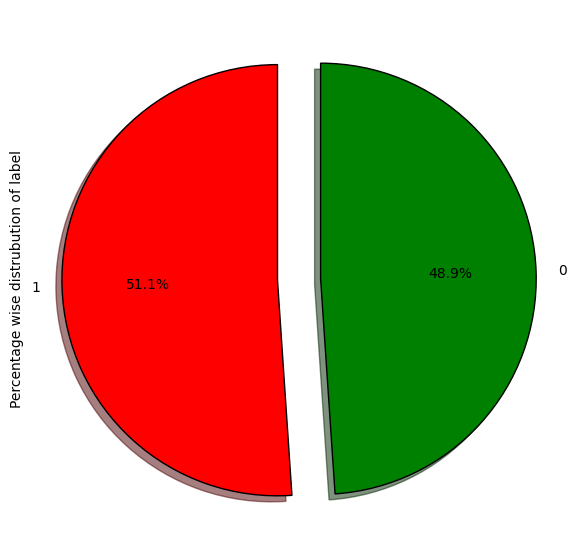

In [19]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['label'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of label')

Let's see the 'rating' values for different values of 'label'

##### If rating of a review is 1 or 2 then the label is 0 (negative) and if the rating is 3, 4 or 5 then the label is 1 (positive).

### Analyzing 'review' column

This column contains the textual review given by the user for a variation for the product.

In [20]:
data['length'].describe()

count    19999.000000
mean       414.971399
std        237.077067
min          6.000000
25%        214.000000
50%        370.000000
75%        582.000000
max       1006.000000
Name: length, dtype: float64

Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review ')]

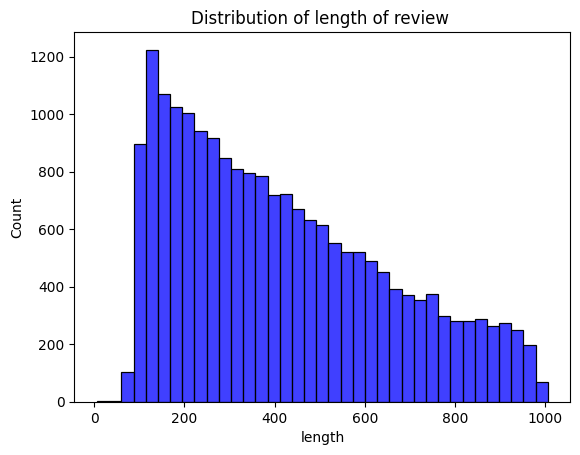

In [21]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

Length analysis when label is 1 (negative)

[Text(0.5, 1.0, 'Distribution of length of review if label = 0')]

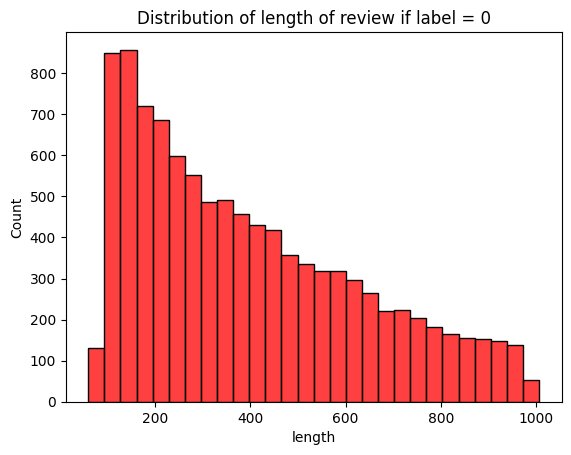

In [22]:
sns.histplot(data[data['label']==1]['length'],color='red').set(title='Distribution of length of review if label = 0')

Length analysis when label is 2 (positive)

[Text(0.5, 1.0, 'Distribution of length of review if label = 1')]

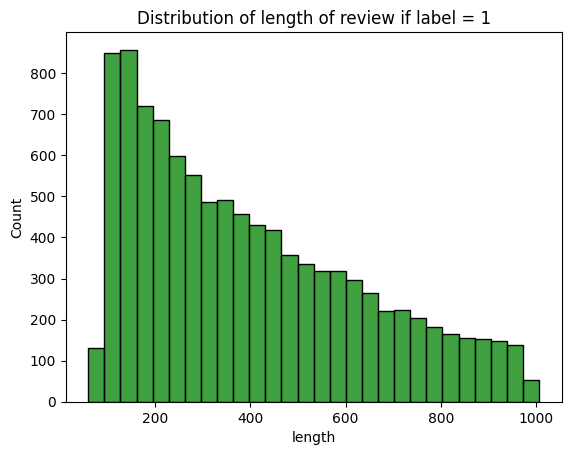

In [23]:
sns.histplot(data[data['label']==1]['length'],color='green').set(title='Distribution of length of review if label = 1')

In [24]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.review)

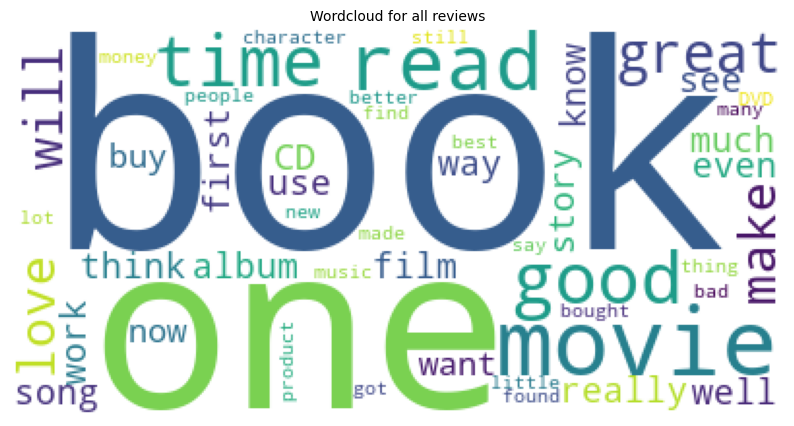

In [25]:
# Combine all reviews
reviews = " ".join([review for review in data['review']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each label category

In [26]:
# Combine all reviews for each label category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['label'] == 0]['review']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['label'] == 1]['review']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that label category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


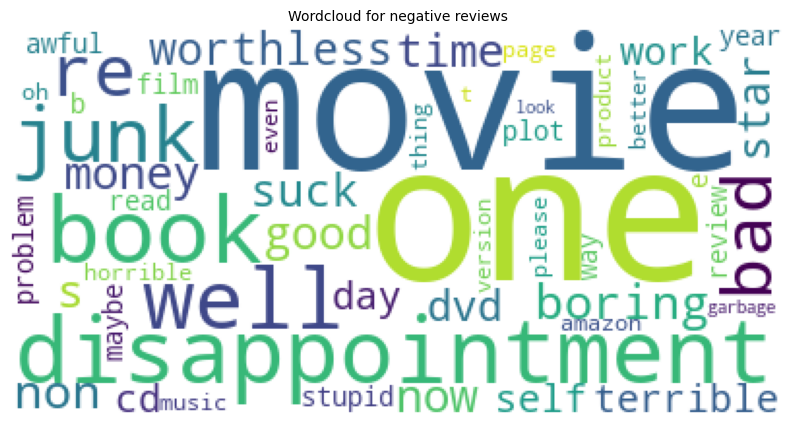

In [27]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

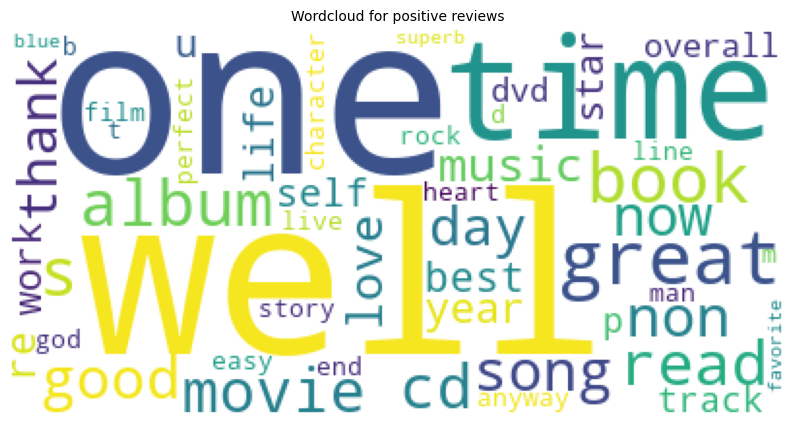

In [28]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Preprocessing and Modelling

To build the corpus from the 'review' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [29]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['review'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [30]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['label'].values

In [31]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

Checking the shape of X and y

In [32]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (19999, 2500)
y shape: (19999,)


Splitting data into train and test set with 30% data with testing.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (13999, 2500)
y train: (13999,)
X test: (6000, 2500)
y test: (6000,)


In [34]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 15
X test max value: 16


We'll scale X_train and X_test so that all values are between 0 and 1.

In [35]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [36]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

#### Random Forest

In [37]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [38]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.8096666666666666


In [39]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [40]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

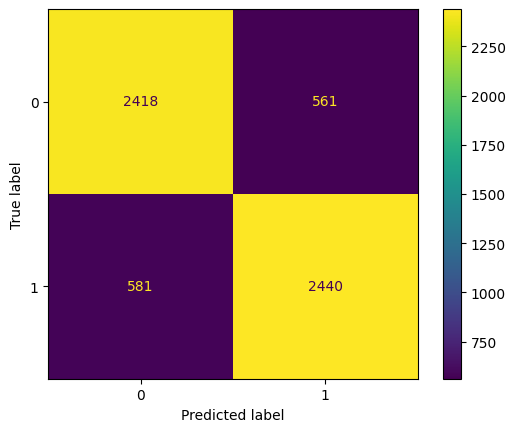

In [41]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [42]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.8077713162462985
Standard Variance : 0.005976728424674462


Applying grid search to get the optimal parameters on random forest

In [43]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [44]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [45]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 300}


In [46]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 98.94722320025309
Cross validation mean accuracy on test set : 80.5164642142755
Accuracy score for test set : 0.8096666666666666


#### XgBoost

In [47]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [48]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9013500964354597
Testing Accuracy : 0.811


In [49]:
y_preds = model_xgb.predict(X_test)

In [50]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[2302  677]
 [ 478 2543]]


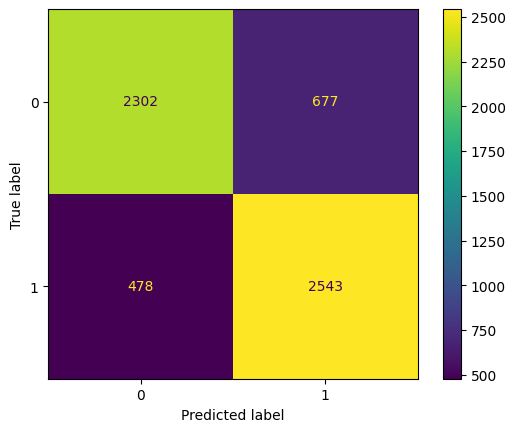

In [51]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [52]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

#### Decision Tree Classifier

In [53]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [54]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.6973333333333334


In [55]:
y_preds = model_dt.predict(X_test)

In [56]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[1950 1029]
 [1112 1909]]


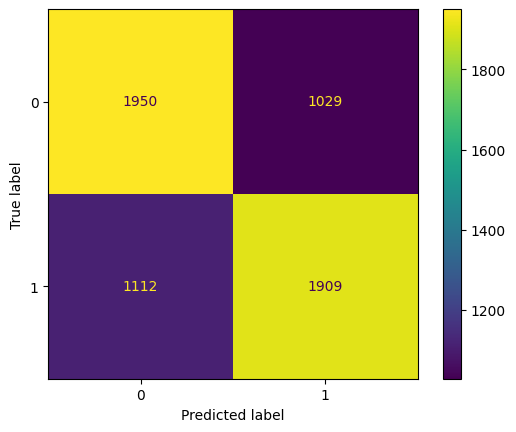

In [57]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()